Generating Data (One seed)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

times = np.arange(0, 500) # step size 1
thetas = 0.3 * np.sin(2*np.pi*times / 100) + 0.5
observations = None # np.array([np.random.binomial(15, theta) for theta in thetas])

Helper functions

In [5]:
from math import factorial as fac
from functools import cache

@cache
def binom(n, p):
    if p > n/2:
        return binom(n, n-p)
    elif p == 0:
        return 1
    else:
        return (binom(n-1, p-1)*n)//p

@cache
def B(a, b):
    return fac(a-1)*fac(b-1) / fac(a+b-1)

Recursive Bayes

In [6]:
# posterior means
def recursive_bayes():
    betas = [[1,1]]
    means = [0.5]
    vars = [np.log(0.083)]
    for obs in observations:
        a, b = betas[-1]
        betas.append([a + obs, b + 15 - obs])
        a, b = a + obs, b + 15 - obs
        
        means.append(a/(a+b)) # mean of beta.
        var = np.log(a) + np.log(b) - 2*np.log(a+b) - np.log(a+b+1)
        vars.append(var)
    return means, vars

BAM no regularization ($\lambda = 0$)

In [7]:
def BAM_noreg():
    means = [0.5]
    vars = [np.log(0.083)]
    for t in range(2, 502):

        W = np.array([0 for _ in range(t-1)])
        scores = [0 for _ in range(t-1)]
        observations_ = observations[:t-1]
        D = observations[t]
        priorScore = -1000 # binom(15, D)*(theta**D)*(1-theta)**(15-D)

        for _ in range(t-1):
            for i in range(t-1): # select best W[i]
                if W[i] == 0:
                    W[i] = 1
                    a, b = 1 + W@observations_, 1 + W@(15 - observations_) 
                    scores[i] = binom(15, D) * B(a + D, b + 15 - D) / B(a, b) 
                    W[i] = 0
                else: # has already been chosen, dont consider again
                    scores[i] = np.NINF
            idx = np.argmax(scores)
            score = scores[idx]
            if score > priorScore:
                W[idx] = 1
                priorScore = score
            else:
                break
        
        # print(sum(W))
        a, b = 1 + W@observations_, 1 + W@(15 - observations_) 
        means.append(a/(a+b))
        var = np.log(a) + np.log(b) - 2*np.log(a+b) - np.log(a+b+1)
        vars.append(var)
    return means, vars

BAM with regularization: $\lambda = 0.1$

In [27]:
from scipy.special import rel_entr
steps = 100
p_2 = [1 for _ in range(steps)]
X = np.arange(0, 1, 1/steps)

@cache
def regularization_term(a_1, b_1):
    p_1 = [(1/B(a_1, b_1)) * (x**(a_1 - 1)) * ((1-x)**(b_1 - 1)) for x in X]
    return -0.6*np.sqrt(2*np.sum(rel_entr(p_1, p_2))*(1/steps))

In [18]:
def BAM_reg():    
    means = [0.5]
    vars = [np.log(0.083)]
    for t in range(2, 502):

        W = np.array([0 for _ in range(t-1)])
        scores = [0 for _ in range(t-1)]
        observations_ = observations[:t-1]
        D = observations[t]
        priorScore = -1000 # binom(15, D)*(theta**D)*(1-theta)**(15-D)

        for _ in range(t-1):
            for i in range(t-1): # select best W[i]
                if W[i] == 0:
                    W[i] = 1
                    a, b = 1 + W@observations_, 1 + W@(15 - observations_) 
                    scores[i] = np.log(binom(15, D) * B(a + D, b + 15 - D) / B(a, b)) + regularization_term(a, b)
                    W[i] = 0
                else: # has already been chosen, dont consider again
                    scores[i] = np.NINF
            idx = np.argmax(scores)
            score = scores[idx]
            if score > priorScore:
                W[idx] = 1
                priorScore = score
            else:
                break
        
        # print(sum(W))
        a, b = 1 + W@observations_, 1 + W@(15 - observations_) 
        means.append(a/(a+b))
        var = np.log(a) + np.log(b) - 2*np.log(a+b) - np.log(a+b+1)
        vars.append(var)
    return means, vars
    

BOCD

In [10]:
from scipy.stats import beta
from scipy.special import logsumexp

def BOCD():
    T = 500
    log_R = -np.inf * np.zeros((T+1, T+1)) # R[i, j] = P(j | i)
    log_R[0, 0] = 0
    max_R = np.empty(T+1)
    max_R[0] = 1
    a = np.array([1])
    b = np.array([1])
    log_message = np.array([0])
    H = 1/100
    log_H = np.log(H)
    log_1mH = np.log(1 - H)

    means = np.empty(T)
    vars = np.empty(T)

    for t in range(1, T+1):
        # 2. observe new data
        x = observations[t-1]

        # make model preds
        means[t-1] = np.sum(np.exp(log_R[t-1, :t]) * (a/(a+b))[:t])
        vars[t-1] = logsumexp(log_R[t-1, :t] + (np.log(a) + np.log(b) - 2*np.log(a+b) - np.log(a+b+1))[:t])
        # + np.sum(np.exp(log_R[t-1, :t]) * ((a/(a+b))**2)[:t]) - means[t-1]**2) # law of total variance

        # 3. evaluate pred. probs.
        log_pis = np.log([beta.pdf(x / 15, a[i], b[i]) for i in range(t)])


        # 4. Calculate growth probs
        log_growth_probs = log_pis + log_message + log_1mH # p(r_t, x<=t)

        # 5. Calculate changepoint probs
        log_cp_prob = logsumexp(log_pis + log_message + log_H)

        # 6. Calculate evidence
        new_log_joint = np.append(log_cp_prob, log_growth_probs)

        # 7. Determine run length distribution.
        log_R[t, :t+1]  = new_log_joint
        log_R[t, :t+1] -= logsumexp(new_log_joint)

        # 8. Update sufficient statistics.
        a = np.append([1], a + x)
        b = np.append([1], b + 15 - x)

        # Pass message.
        log_message = new_log_joint
    
    return means, vars
    

20 Seeds experiment

In [28]:
seeds_recursive = []
seeds_BAM_noreg = []
seeds_BAM_reg = []
seeds_BOCD = []


num_seeds = 20

for _ in range(num_seeds):
    observations = np.array([np.random.binomial(15, theta) for theta in thetas])

    seeds_recursive.append(recursive_bayes())
    seeds_BAM_noreg.append(BAM_noreg())
    seeds_BAM_reg.append(BAM_reg())
    seeds_BOCD.append(BOCD())

    print(_, 'completed')


C:\Users\jonat\AppData\Local\Temp\ipykernel_18792\1823150894.py:17: RuntimeWarning: invalid value encountered in double_scalars
  scores[i] = binom(15, D) * B(a + D, b + 15 - D) / B(a, b)
C:\Users\jonat\AppData\Local\Temp\ipykernel_18792\876413244.py:6: RuntimeWarning: invalid value encountered in multiply
  log_R = -np.inf * np.zeros((T+1, T+1)) # R[i, j] = P(j | i)
C:\Users\jonat\AppData\Local\Temp\ipykernel_18792\876413244.py:30: RuntimeWarning: divide by zero encountered in log
  log_pis = np.log([beta.pdf(x / 15, a[i], b[i]) for i in range(t)])


0 completed
1 completed
2 completed
3 completed
4 completed
5 completed
6 completed
7 completed
8 completed
9 completed
10 completed
11 completed
12 completed
13 completed
14 completed
15 completed
16 completed
17 completed
18 completed
19 completed


In [2]:
import pickle as pkl

# pkl.dump(seeds_recursive, open('seeds_recursive.pkl', 'wb'))
# pkl.dump(seeds_BAM_noreg, open('seeds_BAM_noreg.pkl', 'wb'))
# pkl.dump(seeds_BAM_reg, open('seeds_BAM_reg.pkl', 'wb'))
# pkl.dump(seeds_BOCD, open('seeds_BOCD.pkl', 'wb'))

seeds_recursive = pkl.load(open('seeds_recursive.pkl', 'rb'))
seeds_BAM_noreg = pkl.load(open('seeds_BAM_noreg.pkl', 'rb'))
seeds_BAM_reg = pkl.load(open('seeds_BAM_reg.pkl', 'rb'))
seeds_BOCD = pkl.load(open('seeds_BOCD.pkl', 'rb'))

Plot the means

In [3]:
def get_means(seeds, num_seeds):
    means = [[0 for _ in range(498)] for _ in range(num_seeds)]

    for i in range(num_seeds):
        for j in range(498):
            means[i][j] = seeds[i][0][j]
    means = np.array(means)
    means_mean = np.mean(means, axis = 0)
    return means_mean

means_recursive = get_means(seeds_recursive, 20)
means_noreg = get_means(seeds_BAM_noreg, 20)
means_reg = get_means(seeds_BAM_reg, 20)
means_BOCD = get_means(seeds_BOCD, 20)

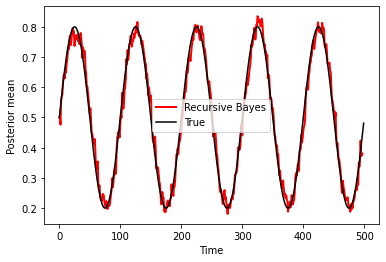

In [5]:
plt.plot(means_BOCD, color = 'r', label = 'Recursive Bayes', linewidth = 2)
plt.plot(thetas, color = 'k', label = 'True', linewidth = 1.5)
plt.xlabel('Time')
plt.ylabel('Posterior mean')
plt.legend()
plt.show()

Plot variances

In [5]:
def get_vars(seeds, num_seeds):
    vars = [[0 for _ in range(498)] for _ in range(num_seeds)]

    for i in range(num_seeds):
        for j in range(498):
            vars[i][j] = seeds[i][1][j]
    vars = np.array(vars)
    vars_mean = np.mean(vars, axis = 0)
    return vars_mean

vars_recursive = get_vars(seeds_recursive, 15)
vars_noreg = get_vars(seeds_BAM_noreg, 15)
vars_reg = get_vars(seeds_BAM_reg, 15)
vars_BOCD = get_vars(seeds_BOCD, 20)

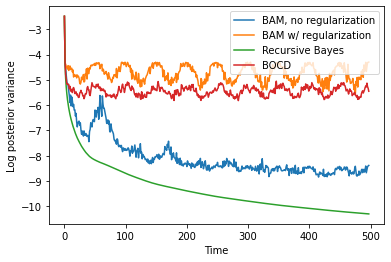

In [6]:
plt.plot(vars_noreg, label = 'BAM, no regularization')
plt.plot(vars_reg, label = 'BAM w/ regularization')
plt.plot(vars_recursive, label = 'Recursive Bayes')
plt.plot(vars_BOCD, label = 'BOCD')
plt.xlabel('Time')
plt.ylabel('Log posterior variance')
plt.legend()
plt.show()

Compute RMSEs

In [9]:
def rmse(thetas, means):
    return np.mean((thetas - means)**2)**0.5

In [10]:
print('Recursive:', rmse(thetas[:-2], means_recursive))
print('BAM:', rmse(thetas[:-2], means_noreg))
print('BAM w/ Reg:', rmse(thetas[:-2], means_reg))
print('BOCD:', rmse(thetas[:-2], means_BOCD))

Recursive: 0.21191333218031352
BAM: 0.03012614356633577
BAM w/ Reg: 0.03383252680053885
BOCD: 0.027271983152513703
